In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, Trainer, TrainingArguments
import torch.nn as nn
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [5]:
print(f"Original classifier: {model.classifier}")  # Should show a layer with 5 outputs

Original classifier: Linear(in_features=768, out_features=5, bias=True)


In [6]:
model.num_labels = 3
model.classifier = nn.Linear(model.config.hidden_size, 3)

In [7]:
print(f"Updated classifier: {model.classifier}")  # Should now show 3 outputs

Updated classifier: Linear(in_features=768, out_features=3, bias=True)


# Finetune BERT

### Comments

In [8]:
def relabel(file):
    df = pd.read_csv(file)
    print(df.head(5))

    df = df.rename(columns={'sentiment': 'label'})

    def map_labels(rating):
        if rating == "negative":
            return 0  # Negative
        elif rating == "neutral":
            return 1  # Neutral
        else:
            return 2

    df['label'] = df['label'].apply(map_labels)
    return df

In [30]:
df2020_all = relabel('./data/r_labeled_comments_2020.csv')
df2024_all = relabel('./data/r_labeled_comments_2024.csv')

                                                text  created_utc  ups  \
0  18 days wut\n\nYou're missing the point, thoug...   1276050379    1   
1  I definitely don't believe that Obama's disapp...   1276053594    3   
2  He's still the president. They should give him...   1287870058    1   
3  As someone who lives in Alabama and has Bedfor...   1291181393    2   
4  I think that pretty much nails it. Anyway, exc...   1291854330    2   

   subreddit    neg    neu    pos  compound sentiment  
0  democrats  0.086  0.824  0.090    0.4885  positive  
1  democrats  0.057  0.807  0.136    0.9931  positive  
2  democrats  0.000  1.000  0.000    0.0000   neutral  
3  democrats  0.086  0.833  0.082   -0.3397  negative  
4  democrats  0.143  0.607  0.251    0.8225  positive  
                                                text  created_utc  ups  \
0  They sure are making the rounds today. Our sys...   1717200019    1   
1  I would say it’s both. Because after a super c...   1717200509    6 

In [31]:
df2020 = df2020_all.sample(n=300, random_state = 42)
df2024 = df2024_all.sample(n=300, random_state = 42)

In [32]:
df2020.head()

,text,created_utc,ups,subreddit,neg,neu,pos,compound,label
22271,"As a latino, I can tell you the only ones boyc...",1594473134,2,Republican,0.132,0.792,0.077,-0.3022,0
18005,I really like that you are a reasonable person...,1583457754,2,democrats,0.049,0.754,0.198,0.9928,2
6024,> Maybe instead of insulting prospective voter...,1484365556,3,democrats,0.093,0.772,0.135,0.9796,2
17105,We would have to impeach and remove Pence befo...,1578001246,2,democrats,0.126,0.853,0.021,-0.8500,0
1644,They had better start acting like Democrats. T...,1425851667,1,democrats,0.122,0.766,0.112,-0.5913,0


In [33]:
# split into train and test data
def split_data(df2020, df2024):
    train_size = int(df2020.shape[0] * 0.8)
    test_size = min(df2020.shape[0] - train_size, df2024.shape[0])    # choose either 20% or the entirety of the df2024 data (whichever is smaller)

    train_df = df2020.sample(n=train_size, random_state=42)      # get random rows
    test_df = df2024.sample(n=test_size, random_state=42)

    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, test_dataset

train_dataset, test_dataset = split_data(df2020, df2024)

In [34]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

In [35]:
print(train_dataset[0])

{'text': 'Thanks for being  an actual president.', 'created_utc': 1546403116, 'ups': 12, 'subreddit': 'democrats', 'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404, 'label': 2, '__index_level_0__': 12518, 'input_ids': [101, 47530, 10139, 11352, 10144, 14284, 11250, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [36]:
print(f"Classifier output size: {model.classifier.out_features}")
print(train_dataset['label'][:100])

Classifier output size: 3
[2, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0]


In [ ]:
# train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [37]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

In [39]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='./logs'
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

eval_log = None
trainer.train()
eval_log = trainer.evaluate()


print(f'Evaluation Log: {eval_log}')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-39-86b41d4ac059>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.660786,0.750000
2,No log,0.616287,0.800000
3,No log,0.725968,0.716667
4,No log,0.816552,0.733333
5,No log,0.995061,0.716667
6,No log,1.193474,0.733333
7,No log,1.225184,0.700000
8,No log,1.270369,0.700000
9,No log,1.387034,0.716667
10,No log,1.443832,0.716667


Evaluation Log: {'eval_loss': 0.6162874698638916, 'eval_accuracy': 0.8, 'eval_runtime': 1.8308, 'eval_samples_per_second': 32.772, 'eval_steps_per_second': 2.185, 'epoch': 15.0}


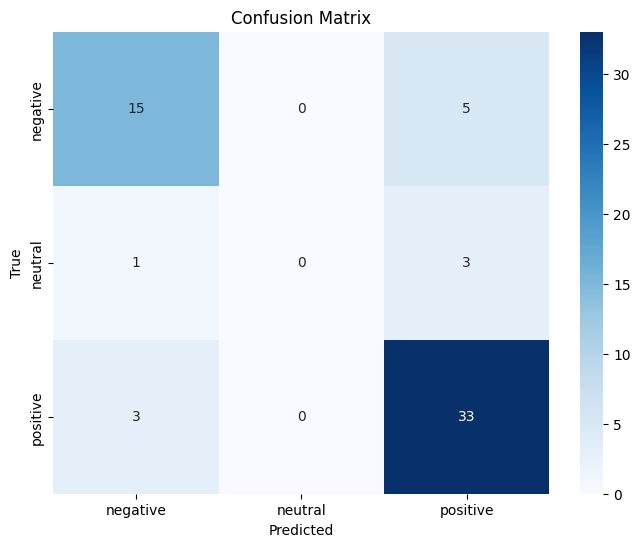

In [40]:
import numpy as np
labels = ['negative', 'neutral', 'positive']
# Get predictions on the test dataset using Trainer.predict()
predictions = trainer.predict(test_dataset)

# Extract predicted labels (argmax of the logits)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Extract true labels
true_labels = predictions.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Posts

In [ ]:
pdf2020 = relabel('./data/labeled_posts_2020.csv')
pdf2024 = relabel('./data/labeled_posts_2024.csv')

train_dataset, test_dataset = split_data(df2020, df2024)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='./logs'
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

eval_log = None
trainer.train()
eval_log = trainer.evaluate()


print(f'Evaluation Log: {eval_log}')